# SARSA with Gridworld

## Goal:

- Adapt from Monte Carlo
- SARSA

In [1]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Make Env

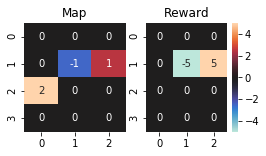

In [2]:
def make_env():
    env = rl.env.Gridworld(shape=(4, 3),
                           start=(2, 0),
                           goal=(1, 2),
                           move_reward=-1)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=20)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env


env = make_env()
env.reset()
env.render()


## Step 2: Define policy

SARSA with policy iteration (with only one-step policy evaluation) using moving average.

In [3]:
class SARSAPolicy(rl.policy.BasePolicy):

    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action

        self.q = np.zeros(list(self.observation_space.high) +
                          [n_action])  # (s0, s1, a)

    def step(self, state):
        # code here ...
        # ...
        return np.argmax(self.q[tuple(state)])  # greedy action selection

    def optimize_step(self, data):
        # code here ...
        # ...
        s, a, r, ss, aa, done = data['s'], data['a'], data['r'], data[
            'ss'], data['aa'], data['done']
        sa = tuple(s) + (a,)  # (s0, s1, a)
        ssaa = tuple(ss) + (aa,)
        td_error = r + (1.0 -
                        done) * self.discount_factor * self.q[ssaa] - self.q[sa]
        self.q[sa] += self.lr * td_error

## Step 3: Define an explorer

Create `OneStepExplorer` to use with SARSA. You could look at the `EpisodeExplorer` for inspirations.

The `OneStepExplorer` should run a given policy only for ONE step then return what it sees.

It should return something like this from its `step` method: 

```
{
    's': current state,
    'a': action,
    'r': reward,
    'ss': next state,
    'aa': next action,
    'done': is done?,
}
```

In [4]:
class OneStepExplorer(rl.explorer.BaseExplorer):
    """explore the environment only one-step then returns the experience immediately"""
    def __init__(self, n_max_interaction, env):
        super().__init__(env)
        self.n_max_interaction = n_max_interaction
        self.last_s = self.env.reset()
        self.n_interaction = 0
        self.n_ep = 0

    def step(self, policy):
        if self.n_interaction >= self.n_max_interaction:
            raise rl.exception.InteractionExceeded()
            
        # code here
        # ...
        
        a = policy.step(self.last_s)
        s, r, done, info = self.env.step(a)
        self.n_interaction += 1

        data = {
            's': self.last_s,
            'a': a,
            'r': r,
            'ss': s,
            'aa': policy.step(s),  # for SARSA
            'done': done,
        }

        self.last_s = s

        if done:
            self.last_s = self.env.reset()
            self.n_ep += 1
            self._update_stats(self.n_interaction, info['episode']['reward'])

        return data


Test the explorer:

In [5]:
rl.util.set_seed(0)
explorer = OneStepExplorer(1, make_env())
explorer.step(rl.policy.RandomPolicy(n_action=4))

{'s': array([2, 0]),
 'a': 3,
 'r': -1,
 'ss': array([2, 1]),
 'aa': 3,
 'done': False}

Expected result: 

```
{'s': array([2, 0]),
 'a': 3,
 'r': -1,
 'ss': array([2, 1]),
 'aa': 3,
 'done': False}
```

In [6]:
explorer.step(rl.policy.RandomPolicy(n_action=4))

InteractionExceeded: 

Expected result: `InteractionExceeded` exception raised.

## Running the algorithm

In [7]:
def run(policy, n_max_interaction):
    rl.util.set_seed(0) # predictable results
    env = make_env()
    explorer = OneStepExplorer(n_max_interaction=n_max_interaction, env=env)

    while True:
        try:
            data = explorer.step(policy)
            policy.optimize_step(data)  # not defined
        except rl.exception.InteractionExceeded:
            break
    df = pd.DataFrame(explorer.get_stats()['history'])
    return df

max: 2


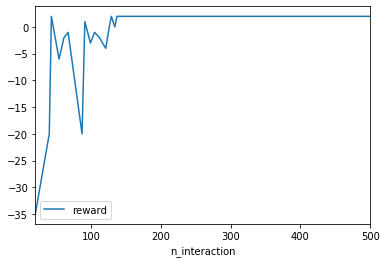

In [8]:
policy = SARSAPolicy(lr=0.1,
                     discount_factor=0.99,
                     observation_space=env.observation_space,
                     n_action=env.action_space.n)

stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Expected result: In our implementation, we could get ~2 reward under 500 iteractions.

# Q1: Even without an explicit exploration like epsilon greedy, SARSA seems to work! Why is that the case? What works as an "implicit" exploration?

Describe here ...

Answer: there is an implicit exploration which is -1 reward for each step. This implicit exploration is fortunately enough in this case.

# Q2: Show us then when an explicit exploration would be important? 

Create code blocks (and run them) as needed to proof your argument by comparing results SARSA vs. SARSA + epsilon greedy 

Plots are welcome.

In [9]:
class EpsilonGreedy(rl.policy.BasePolicyWrapper):
    def __init__(self, policy):
        self.policy = policy

    def step(self, state):
        # code here ...
        # ...
        if random.random() < 0.1:
            return random.randint(0, 3)
        else:
            return self.policy.step(state)

Create blocks as needed ...

## Possible answer: changing the move reward = 0

In [10]:
def make_env():
    env = rl.env.Gridworld(shape=(4, 3),
                           start=(2, 0),
                           goal=(1, 2),
                           move_reward=0)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=20)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env

SARSA without epsilon greedy

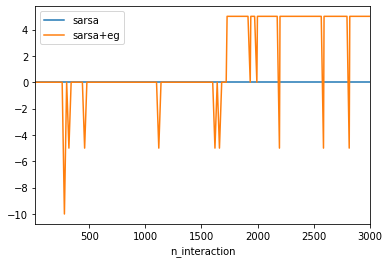

In [18]:
policy = SARSAPolicy(lr=0.1,
                     discount_factor=0.99,
                     observation_space=env.observation_space,
                     n_action=env.action_space.n)
sarsa = run(policy, 3000)

policy = SARSAPolicy(lr=0.1,
                     discount_factor=0.99,
                     observation_space=env.observation_space,
                     n_action=env.action_space.n)
policy = EpsilonGreedy(policy)
sarsa_eg = run(policy, 3000)

ax = plt.subplot()
sarsa.plot(x='n_interaction', y='reward', ax=ax)
sarsa_eg.plot(x='n_interaction', y='reward', ax=ax)
ax.legend(['sarsa', 'sarsa+eg'])